This is just going to train a simple model using the converted images.
It's very similar to the [first lesson of fastai](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson1-pets.ipynb).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate, accuracy
from fastai.callbacks import SaveModelCallback
from tqdm import tqdm_notebook as tqdm
from src.paths import TRAIN_FOLDER, TEST_FOLDER, SUBMISSION_CSV

In [3]:
label_pattern = r'/([^/]+)_\d+.jpg$'
BATCH_SIZE=64

In [4]:
np.random.seed(2)
data = ImageDataBunch.from_name_re(
    path=TRAIN_FOLDER,
    fnames=get_image_files(TRAIN_FOLDER),
    pat=label_pattern,
    ds_tfms=get_transforms(do_flip=False),
    size=224,
    bs=BATCH_SIZE
).normalize(imagenet_stats)

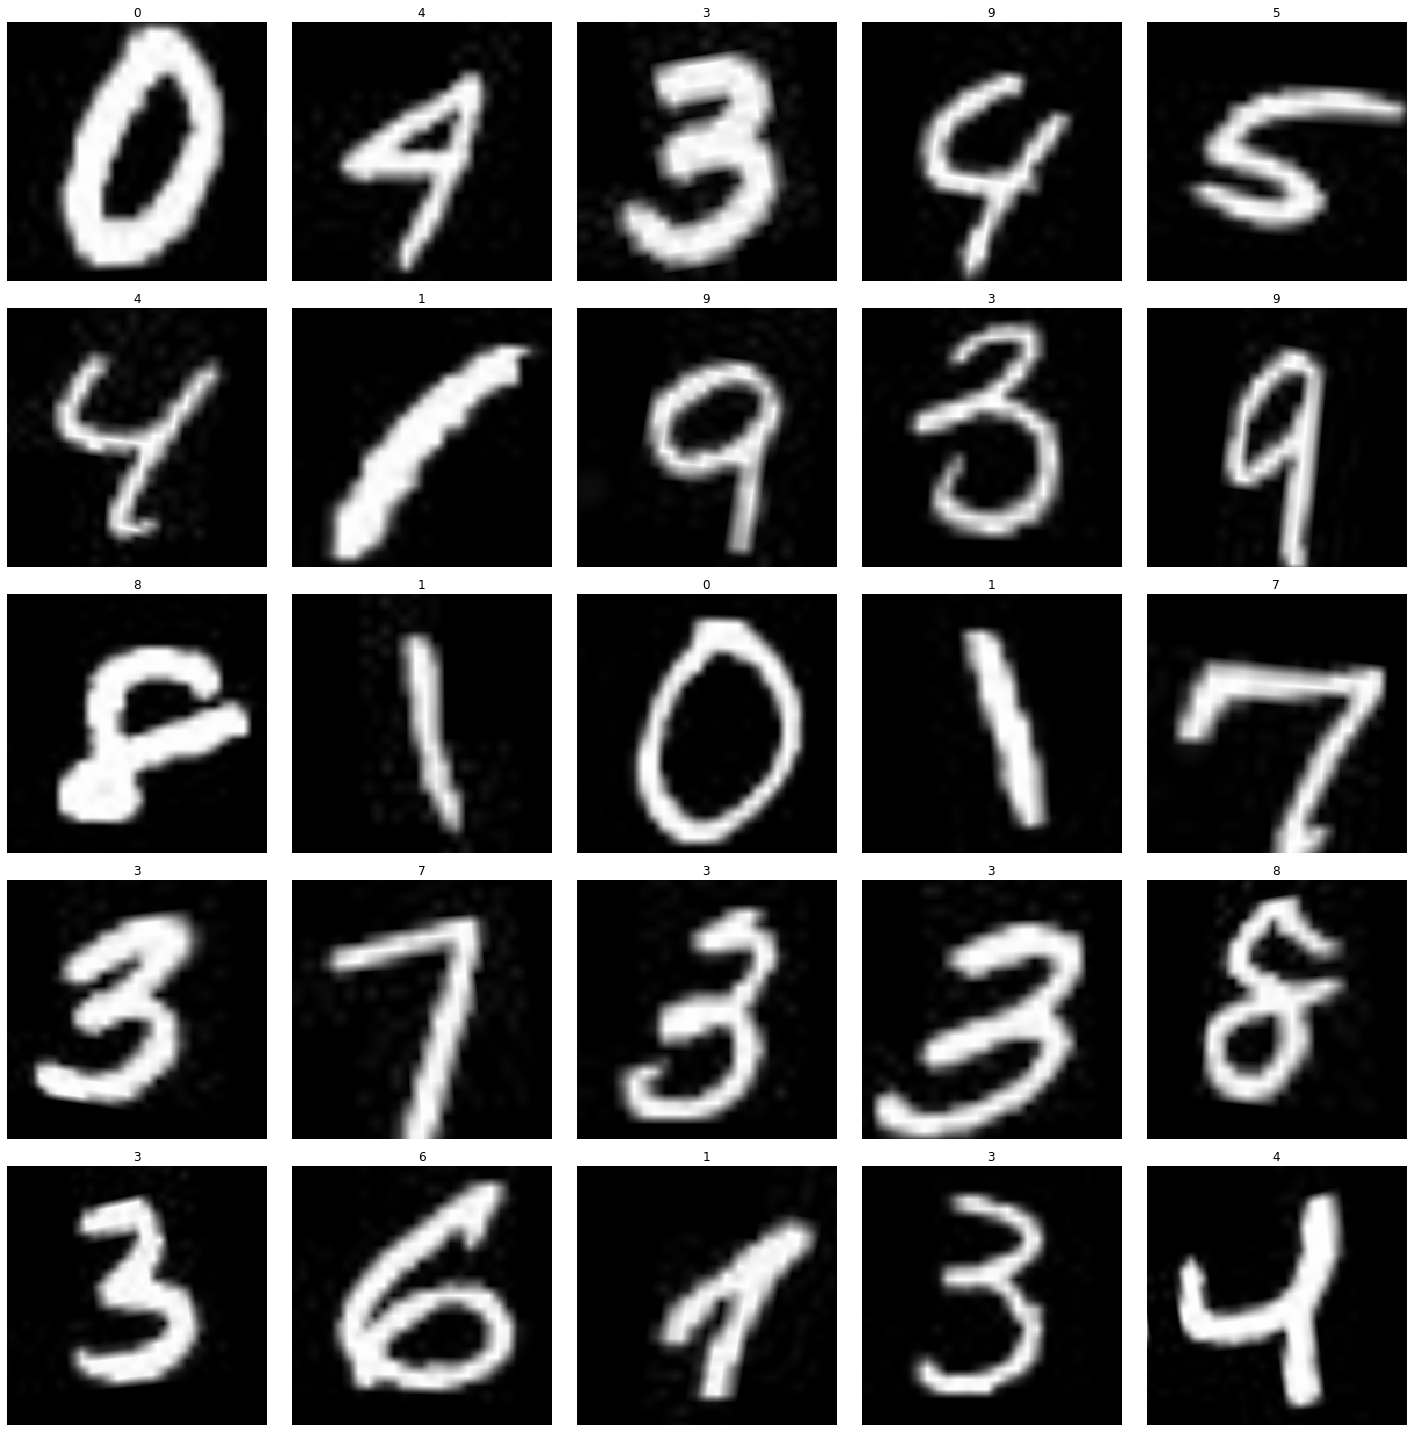

In [5]:
data.show_batch()

In [6]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-03
Min loss divided by 10: 2.51E-02


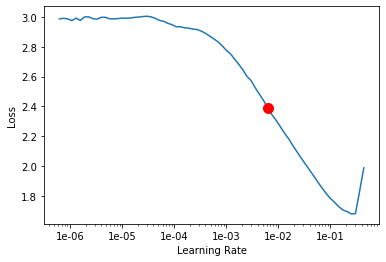

In [7]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [8]:
learn.fit_one_cycle(20, max_lr=1.10E-02, callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy')])

In [9]:
learn.save('r18-stage-1-bs64')

In [10]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-08
Min loss divided by 10: 7.76E-08


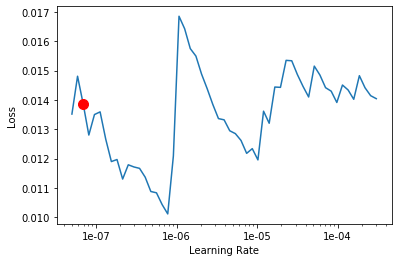

In [11]:
learn.lr_find(start_lr=1.E-8, end_lr=1.E-1)
learn.recorder.plot(suggestion=True)

In [12]:
end_lr = 7.76E-08
start_lr = end_lr / 9

learn.fit_one_cycle(
    20,
    max_lr=slice(start_lr, end_lr),
    callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy')]
)

In [13]:
learn.save('r18-stage-2')

In [44]:
sorted(TEST_FOLDER.ls())[:5]

[PosixPath('/home/matthew/Programming/Kaggle/digit-recognizer/data/processed/test/000000.jpg'),
 PosixPath('/home/matthew/Programming/Kaggle/digit-recognizer/data/processed/test/000001.jpg'),
 PosixPath('/home/matthew/Programming/Kaggle/digit-recognizer/data/processed/test/000002.jpg'),
 PosixPath('/home/matthew/Programming/Kaggle/digit-recognizer/data/processed/test/000003.jpg'),
 PosixPath('/home/matthew/Programming/Kaggle/digit-recognizer/data/processed/test/000004.jpg')]

In [58]:
def predict(model, path):
    image = open_image(path)
    prediction, _, _ = model.predict(image)
    return prediction

/home/matthew/Programming/Kaggle/digit-recognizer/data/processed/test/000000.jpg 2


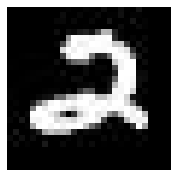

In [52]:
path = sorted(TEST_FOLDER.ls())[0]
image = open_image(path)
prediction, _, _ = learn.predict(image)
show_image(image)
print(path, prediction)

In [63]:
paths = sorted(TEST_FOLDER.ls())
ids = list(range(1, len(paths) + 1))
predictions = [
    predict(learn, path)
    for path in tqdm(paths)
]
len(ids)==len(predictions)

True

In [66]:
df = pd.DataFrame({'ImageId': ids, 'Label': predictions}).set_index('ImageId')

In [67]:
df.head()

Label
ImageId      
1           2
2           0
3           9
4           0
5           3

In [68]:
df.to_csv(SUBMISSION_CSV)

1686 Matthew Franglen 0.98271